In [1]:
import pickle
import random
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.manifold import TSNE

from src.parse_data.compute_generic_embed_means import (
    TEXT_VIDEOCLIP_EMBED_MEAN, 
    VIDEO_EMBED_MEAN, 
    TEXT_CONVIRT_EMBED_MEAN,
    MED_IMAGES_EMBED_MEAN,
    TEXT_CLASP_EMBED_MEAN,
    AMINO_ACID_EMBED_MEAN
)
from src.enums import Modality, DatasetType

/pasteur/u/esui/miniconda3/envs/clip_prefix_caption/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_data_paths(dataset_type):
    if dataset_type == DatasetType.Video:
        data_path =  '/pasteur/u/esui/data/c3/data_videoclip_train.pkl'
        # data_path = '/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/data_videoclip.pkl'
        text_mean_path = TEXT_VIDEOCLIP_EMBED_MEAN
        x_mean_path = VIDEO_EMBED_MEAN
    elif dataset_type == DatasetType.Medical:
        data_path =  '/pasteur/u/esui/data/c3/data_convirt_train.pkl'
        # data_path = '/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/data_convirt.pkl'
        text_mean_path = TEXT_CONVIRT_EMBED_MEAN
        x_mean_path = MED_IMAGES_EMBED_MEAN
    elif dataset_type == DatasetType.Amino_Acid:
        data_path =  '/pasteur/u/esui/data/c3/data_clasp_train.pkl'
        # data_path = '/pasteur/u/yuhuiz/archive/neurips_modality_gap/pull_figure/data_clasp.pkl'
        text_mean_path = TEXT_CLASP_EMBED_MEAN
        x_mean_path = AMINO_ACID_EMBED_MEAN
    else:
        raise NotImplementedError(f"dataset type {dataset_type} not implemented")
    
    return data_path, text_mean_path, x_mean_path


def sample_embeds(modality, n, dataset_type):
    data_path, text_mean_path, x_mean_path = get_data_paths(dataset_type)

    if modality == Modality.Vision:
        embed_mean_path = x_mean_path
        embed_key = "x_embed"
    else:
        embed_mean_path = text_mean_path
        embed_key = "y_embed"
    
    print("=> Loading mean")
    with open(embed_mean_path, 'rb') as f:
        embed_mean = pickle.load(f)
    
    with open(data_path, 'rb') as f:
        data = pickle.load(f)
    
    indices = random.sample(range(len(data)), n)
    
    embeds = [data[idx][embed_key].squeeze() for idx in indices]
    embeds = np.stack(embeds)
    embeds = embeds / np.linalg.norm(embeds, axis=1).reshape(-1, 1)
    
    return embeds, embed_mean


def plot(dataset_type, n=100):
    embeds_language, embed_mean_language = sample_embeds(Modality.Language, n, dataset_type)
    embeds_vision, embed_mean_vision = sample_embeds(Modality.Vision, n, dataset_type)
    print(embed_mean_language.shape)
    print(embed_mean_vision.shape)
    
    tsne = TSNE()
    
    embeds = np.vstack([embeds_language, embeds_vision])
    embeds_removed_mean = np.vstack([embeds_language - embed_mean_language.numpy(),
                                    embeds_vision - embed_mean_vision.numpy()])
    
    two_dimensional_embeds = tsne.fit_transform(embeds)
    
    plt.clf()
    plt.figure()
    plt.title(f"normed embeds")
    plt.scatter(two_dimensional_embeds[:100, 0], two_dimensional_embeds[:100, 1], color='red')
    plt.scatter(two_dimensional_embeds[100:, 0], two_dimensional_embeds[100:, 1], color='blue')
    plt.show()
    
    two_dimensional_embeds = tsne.fit_transform(embeds_removed_mean)
    
    plt.clf()
    plt.figure()
    plt.title(f"normed embeds removed mean")
    plt.scatter(two_dimensional_embeds[:100, 0], two_dimensional_embeds[:100, 1], color='red')
    plt.scatter(two_dimensional_embeds[100:, 0], two_dimensional_embeds[100:, 1], color='blue')
    plt.show()
    
def compute_residual(dataset_type, n=200):
    embeds_language, embed_mean_language = sample_embeds(Modality.Language, n, dataset_type)
    embeds_vision, embed_mean_vision = sample_embeds(Modality.Vision, n, dataset_type)
    
    gap = (embeds_language - embed_mean_language.numpy()) - (embeds_vision - embed_mean_vision.numpy())
    
    print(f"Norm of gap after subtracting means: {np.linalg.norm(gap)}")

=> Loading mean
=> Loading mean


<Figure size 640x480 with 0 Axes>

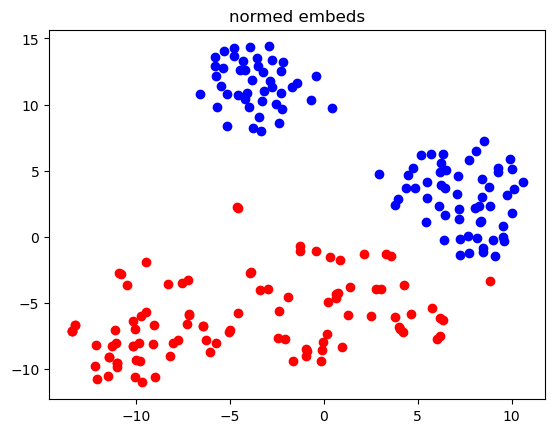

<Figure size 640x480 with 0 Axes>

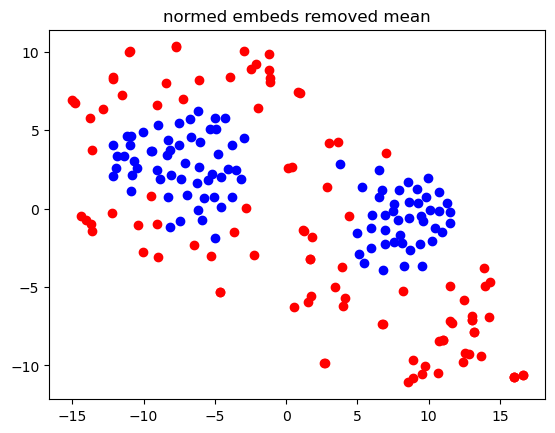

=> Loading mean
=> Loading mean
Norm of gap after subtracting means: 14.970142364501953


In [15]:
plot(dataset_type='medical')
compute_residual(dataset_type='medical')

=> Loading mean
=> Loading mean


<Figure size 640x480 with 0 Axes>

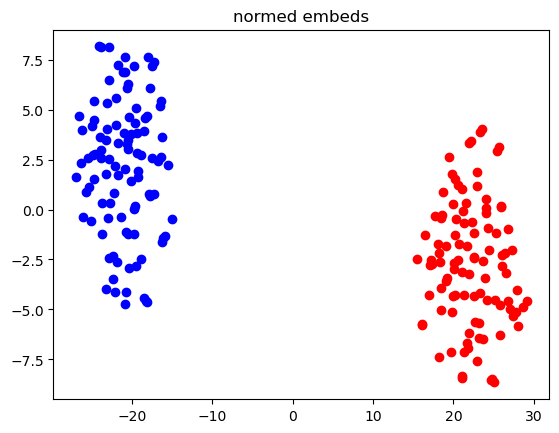

<Figure size 640x480 with 0 Axes>

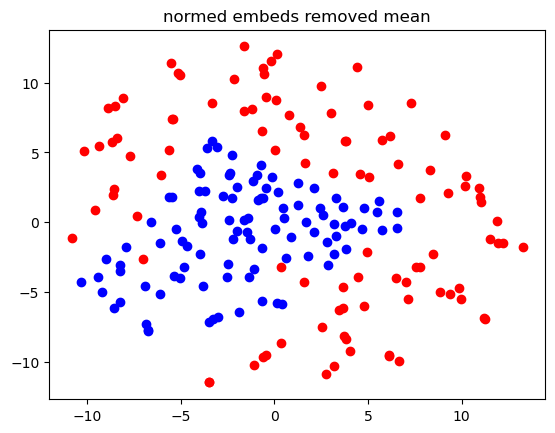

=> Loading mean
=> Loading mean
Norm of gap after subtracting means: 12.592034339904785


In [16]:
plot(dataset_type='video')
compute_residual(dataset_type='video')

=> Loading mean
=> Loading mean


<Figure size 640x480 with 0 Axes>

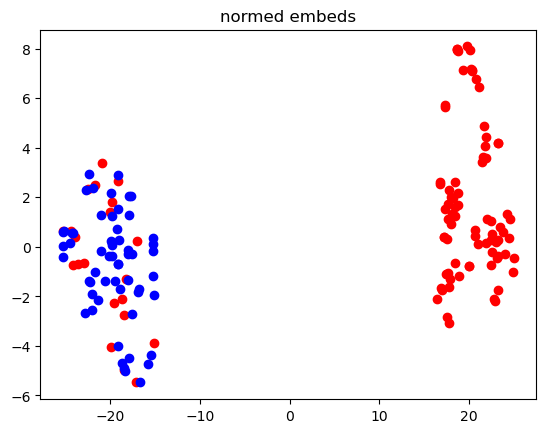

<Figure size 640x480 with 0 Axes>

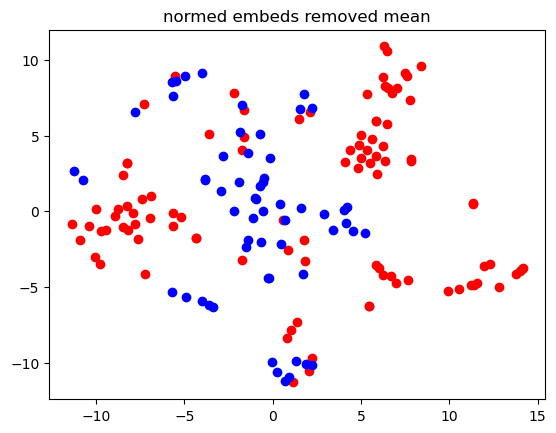

=> Loading mean
=> Loading mean
Norm of gap after subtracting means: 7.2934651374816895


In [17]:
plot(dataset_type='amino_acid', n=79)
compute_residual(dataset_type='amino_acid', n=79)

In [3]:
dataset_type = 'video'
data_path, text_mean_path, x_mean_path = get_data_paths(dataset_type)

with open(data_path, 'rb') as f:
    data = pickle.load(f)

print(data[0]['y'])
print(data[10]['y'])
print(data[100]['y'])

a red clock hands are moved to set it to read 9:00. there is a red clock on the table. an extremely old film intro showing the time passing by. fifties music plays in the background as we zoom in on an analog clock ticking away. an old clip of a movie displays a clock or timer spinning around in a circle. the red clock handles move around really fast. a red frame and silver ring surround a round clock with black hands moving over a gray band and pointing at equal measurements. a clock hands are moving fast on a red clock. the clock says no time waste for any one of the peoples. a red color border clock is in the scene. a close up of a red rimmed clock with the hands moving. the small and large needles moving fast in a clock. a person being very nice talkative and attentive. music playing while looking at a clock. music is playing and there is a clock moving very fast. a fast moving clock with music playing in the background. watching that hands of the red clock move around the face. on